In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)


228813984/228813984 [==============================] - 3s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


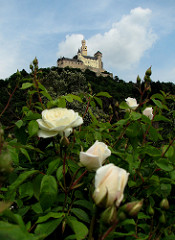

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

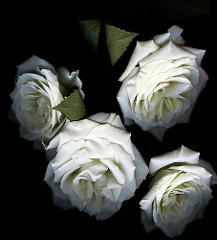

In [ ]:
PIL.Image.open(str(roses[1]))

In [ ]:
# rose dir

image_roses=data_dir/'roses'
img_files=list(image_roses.glob('*.jpg'))

rose_image=img_files[10]
image=PIL.Image.open(rose_image)
print(image.height,image.width)

245 320


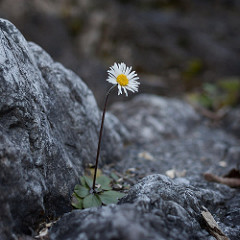

In [ ]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

In [ ]:
# Create a Training Dataset
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     subset='training',
                                                     seed=123,
                                                     image_size=(180,180),
                                                     batch_size=32
                                                     )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# Create a Validation Dataset
test_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=123,
                                                     image_size=(180,180),
                                                     batch_size=32
                                                     )

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


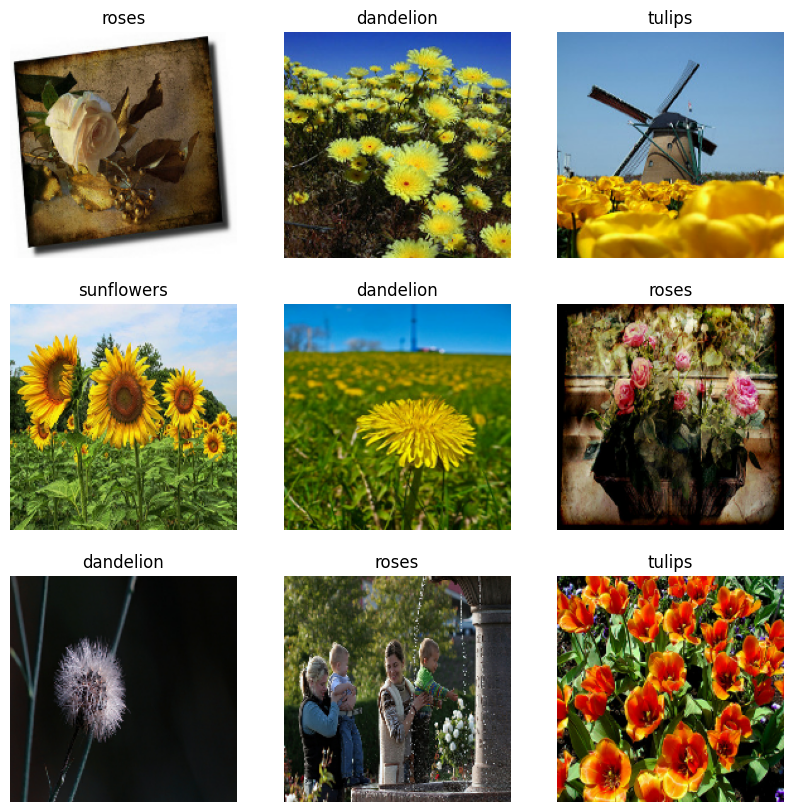

In [ ]:
# display images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

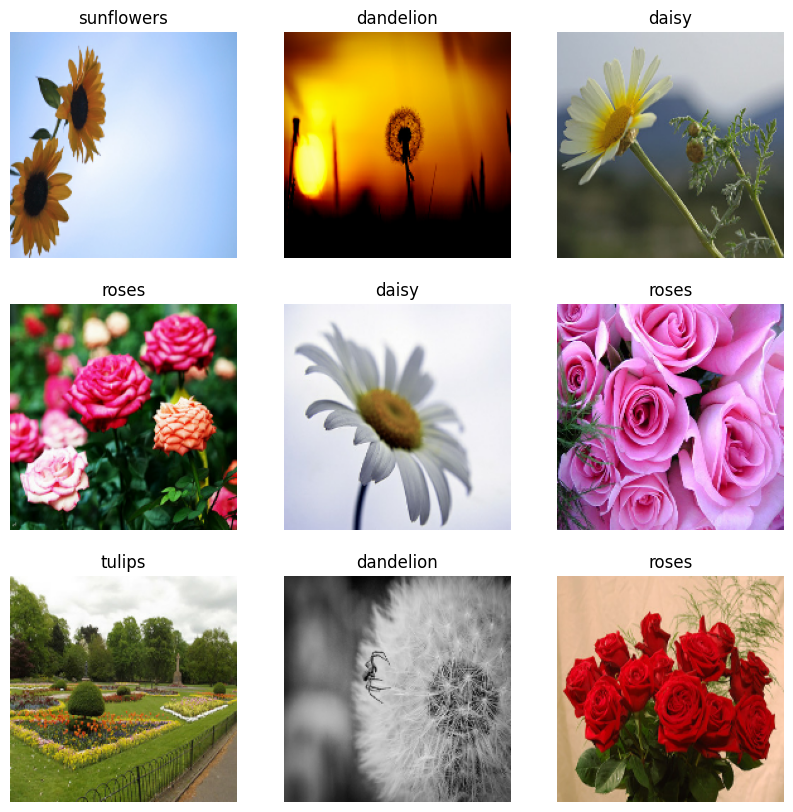

In [ ]:
# display images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

tune the numbers of parallel calls during data preprocessing, transformation operations

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# data Normalization
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = 5
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Feature Extraction

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
# Freeze the weights of the pre-trained layers
base_model.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

## Add output layer

In [ ]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = normalization_layer(x)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
# Create the new model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile and train the model on the new dataset
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=2, validation_data=(test_ds))

Epoch 1/2
92/92 [==============================] - 29s 236ms/step - loss: 4.5717 - accuracy: 0.7047 - val_loss: 0.8082 - val_accuracy: 0.7916
Epoch 2/2
92/92 [==============================] - 10s 105ms/step - loss: 0.3493 - accuracy: 0.8849 - val_loss: 0.8229 - val_accuracy: 0.7847


In [ ]:
# test accuracy
print('Test Score',model.evaluate(test_ds))


# test accuracy
print('Train Score',model.evaluate(train_ds))

23/23 [==============================] - 2s 84ms/step - loss: 0.8229 - accuracy: 0.7847
Test Score [0.8228558301925659, 0.7847411632537842]
92/92 [==============================] - 8s 84ms/step - loss: 0.1386 - accuracy: 0.9540
Train Score [0.13862431049346924, 0.9540190696716309]


# Fine Tuning

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=((180, 180, 3)))
# Freeze the initial layers and fine-tune the later layers
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Add new classification layers
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = normalization_layer(x)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
# Create the new model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile and train the model on the new dataset
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=3, validation_data=(test_ds))

Epoch 1/3
92/92 [==============================] - 12s 114ms/step - loss: 4.8554 - accuracy: 0.6815 - val_loss: 0.9888 - val_accuracy: 0.7316
Epoch 2/3
92/92 [==============================] - 10s 105ms/step - loss: 0.3430 - accuracy: 0.8828 - val_loss: 0.9295 - val_accuracy: 0.7820
Epoch 3/3
92/92 [==============================] - 10s 105ms/step - loss: 0.1393 - accuracy: 0.9557 - val_loss: 0.8340 - val_accuracy: 0.7984


In [ ]:
# test accuracy
print('Test Score',model.evaluate(test_ds))


# test accuracy
print('Train Score',model.evaluate(train_ds))

23/23 [==============================] - 2s 86ms/step - loss: 0.8340 - accuracy: 0.7984
Test Score [0.8339608311653137, 0.7983651161193848]
92/92 [==============================] - 8s 84ms/step - loss: 0.0769 - accuracy: 0.9755
Train Score [0.07688082009553909, 0.975476861000061]
